## Classifying Fashion-MNIST

You will have to create a classification model for the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) dataset, a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network.

In [1]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [2]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Let's see a random sample

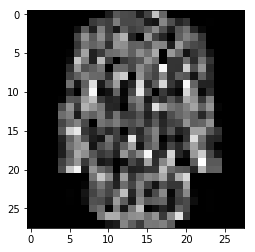

In [6]:
import helper
ind = np.random.permutation(X_train.shape[0])
plt.imshow(X_train[ind[0],:].reshape(28,28), cmap='gray');

Preparing the data for a training process...

In [7]:
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler

input_dim = X_train.shape[1]

scaler = StandardScaler()
X_trainN = scaler.fit_transform(X_train)
X_testN = scaler.transform(X_test)

# convert list of labels to binary class matrix
y_trainOHE = np_utils.to_categorical(y_train)
nb_classes = y_trainOHE.shape[1]

Using TensorFlow backend.


## Define the network architecture using keras

### Sequential models

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([
    Dense(32, input_shape=(input_dim,)),
    Activation('tanh'),
    Dense(nb_classes),
    Activation('softmax'),
])

or

In [19]:
del model
model = Sequential()
model.add(Dense(64, input_dim=input_dim))
model.add(Activation('tanh'))
model.add(Dense(32))
model.add(Activation('tanh'))
model.add(Dense(nb_classes, activation='softmax'))

**Assignment**: Take a look to the core layers in keras: https://keras.io/layers/core/ and the set of basic parameters https://keras.io/layers/about-keras-layers/

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_6 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


Once the arquictecture of model has been defined, the next step is to set the loss function and optimizer

In [21]:
# pass optimizer by name: default parameters will be used
model.compile(loss='categorical_crossentropy', optimizer='sgd')

from keras import optimizers
# or instantiate an optimizer before passing it to model.compile
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

Remember the definition of cross entropy:

$$\mathcal{L}({\bf{\hat{y}}},{\bf{y}}) = -\frac{1}{N}\sum_{i=1}^N y_i\log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)$$

The categorical cross entropy can be defined as:

$$\mathcal{L}({\bf{\hat{y}}},{\bf{y}}) = -\frac{1}{N}\sum_{i=1}^N \sum_{j=1}^C {\bf{1}}_{y_i \in C_j} \log p_{model}[y_i \in C_j]$$

The term ${\bf{1}}_{y_i \in C_j}$ is the indicator function of the $i$-th observation belonging to the $j$-th category. The $p_{model}[y_i \in C_j]$ is the probability predicted by the model for the $i$-th observation to belong to the $j$-th category. When there are more than two categories, the neural network outputs a vector of $C$ probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability $\hat{y}_i$, with the other one being $1$ minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it. 

**Note**. If insteat of a multi-class problem we would be facing a multi-label classification problem, the activation function of the last layer must be a **sigmoid** and the loss function **binary_crossentropy**.

Take a look to compile and fit parameters https://keras.io/models/model/#compile

In [22]:
print("Training...")
model.train_on_batch(X_trainN, y_trainOHE)

print("Generating test predictions...")
preds = model.predict(X_testN[0,:].reshape(1,input_dim), verbose=0)

Training...
Generating test predictions...


real class
9


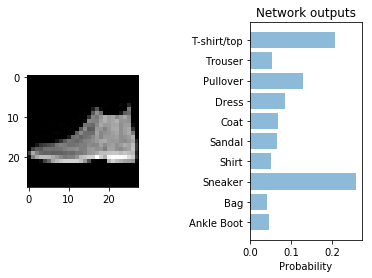

In [23]:
print('real class')
print(y_test[0])

objects = ('Ankle Boot', 'Bag', 'Sneaker', 'Shirt', 'Sandal', 'Coat', 'Dress', 'Pullover', 'Trouser', 'T-shirt/top')
y_pos = np.arange(nb_classes)
performance = preds.flatten()
plt.subplot(121)
plt.imshow(X_test[0,:].reshape(28,28), cmap='gray');
plt.subplot(122) 
plt.barh(y_pos[::-1], performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Network outputs')
plt.subplots_adjust(wspace = 1)
plt.show()

In [24]:
print("Training...")
model.fit(X_trainN, y_trainOHE, epochs=10, batch_size=16, validation_split=0.1, verbose=2)

Training...
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
 - 4s - loss: 0.4595 - val_loss: 0.3960
Epoch 2/10
 - 4s - loss: 0.3690 - val_loss: 0.3813
Epoch 3/10
 - 4s - loss: 0.3375 - val_loss: 0.3822
Epoch 4/10
 - 4s - loss: 0.3179 - val_loss: 0.3522
Epoch 5/10
 - 4s - loss: 0.3015 - val_loss: 0.3487
Epoch 6/10
 - 4s - loss: 0.2848 - val_loss: 0.3683
Epoch 7/10
 - 4s - loss: 0.2725 - val_loss: 0.3626
Epoch 8/10
 - 4s - loss: 0.2663 - val_loss: 0.3644
Epoch 9/10
 - 4s - loss: 0.2576 - val_loss: 0.3483
Epoch 10/10
 - 4s - loss: 0.2473 - val_loss: 0.3703


Generating test predictions...


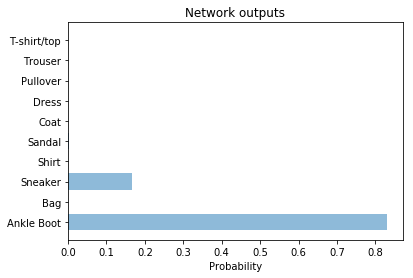

In [25]:
print("Generating test predictions...")
preds = model.predict(X_testN[0,:].reshape(1,input_dim), verbose=0)
performance = preds.flatten()
 
plt.barh(y_pos[::-1], performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Network outputs')
 
plt.show()

In [26]:
preds = model.predict_classes(X_testN, verbose=0)
Accuracy = np.mean(preds == y_test)
print('Accuracy = ', Accuracy*100, '%')

Accuracy =  86.39 %


([<matplotlib.axis.YTick at 0x134d92877b8>,
 <a list of 10 Text yticklabel objects>)

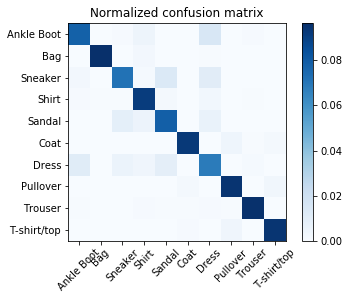

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)
cm = cm/np.sum(cm)
cmap = plt.cm.Blues
tick_marks = np.arange(nb_classes)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects)

### Functional models

The Keras functional API provides a more flexible way for defining models.

It allows you to define multiple input or output models as well as models that share layers. More than that, it allows you to define ad hoc acyclic network graphs.

Models are defined by creating instances of layers and connecting them directly to each other in pairs, then defining a Model that specifies the layers to act as the input and output to the model.

In [11]:
from keras.layers import Input, Dense
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(784,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64, activation='tanh')(inputs)
x = Dense(32, activation='tanh')(x)
predictions = Dense(nb_classes, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(X_trainN, y_trainOHE, epochs=10, batch_size=16, validation_split=0.1, verbose=2)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
 - 4s - loss: 0.5532 - acc: 0.8175 - val_loss: 0.4135 - val_acc: 0.8538
Epoch 2/10
 - 4s - loss: 0.3914 - acc: 0.8614 - val_loss: 0.3843 - val_acc: 0.8635
Epoch 3/10
 - 4s - loss: 0.3509 - acc: 0.8761 - val_loss: 0.3613 - val_acc: 0.8705
Epoch 4/10
 - 4s - loss: 0.3250 - acc: 0.8849 - val_loss: 0.3552 - val_acc: 0.8723
Epoch 5/10
 - 4s - loss: 0.3050 - acc: 0.8911 - val_loss: 0.3377 - val_acc: 0.8790
Epoch 6/10
 - 4s - loss: 0.2882 - acc: 0.8977 - val_loss: 0.3377 - val_acc: 0.8767
Epoch 7/10
 - 4s - loss: 0.2741 - acc: 0.9029 - val_loss: 0.3347 - val_acc: 0.8812
Epoch 8/10
 - 4s - loss: 0.2609 - acc: 0.9069 - val_loss: 0.3301 - val_acc: 0.8827
Epoch 9/10
 - 4s - loss: 0.2485 - acc: 0.9120 - val_loss: 0.3361 - val_acc: 0.8798
Epoch 10/10
 - 4s - loss: 0.2385 - acc: 0.9164 - val_loss: 0.3342 - val_acc: 0.8823


In [18]:
preds = model.predict(X_testN, verbose=0)
preds = np.argmax(preds,axis=1)
Accuracy = np.mean(preds == y_test)
print('Accuracy = ', Accuracy*100, '%')

Accuracy =  87.05000000000001 %


**Note**. Take a look to the keras functional API available on https://keras.io/getting-started/functional-api-guide/

## Exercises

### 1.1 Regularization

1.1.1 Define a new model using the keras sequential API. The model must have four hidden layers with the folloeing neurons [128,64,32,16]. For all the hidden layers use the 'relu' activation function.

In [147]:
from numpy.random import seed
from tensorflow import set_random_seed
from keras import regularizers
seed(1)
set_random_seed(2)

del model
....

Run the following cell to train and test the model defined.

In [ ]:
# or instantiate an optimizer before passing it to model.compile
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_trainN[:500,:], y_trainOHE[:500,:], epochs=1000, batch_size=16, validation_split=0, verbose=0)

preds = model.predict(X_testN, verbose=0)
preds = np.argmax(preds,axis=1)
Accuracy = np.mean(preds == y_test)
print('Accuracy = ', Accuracy*100, '%')

Create a graph with the histogram of the network weigths in the first hidden layer

1.1.2 Modify the former model to include $L_2$ regularization to every layer of the former model. Define a regularization parameter equal to 0.0001. 

In [155]:
seed(1)
set_random_seed(2)

del model
....

Run the following cell to train and test the model

In [ ]:
# or instantiate an optimizer before passing it to model.compile
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_trainN[:500,:], y_trainOHE[:500,:], epochs=1000, batch_size=16, validation_split=0, verbose=0)

preds = model.predict(X_testN, verbose=0)
preds = np.argmax(preds,axis=1)
Accuracy = np.mean(preds == y_test)
print('Accuracy = ', Accuracy*100, '%')

Create a graph with the histogram of the network weigths in the first hidden layer. Compare it with the histogram obtained in the previous exercise. Is there any effect due to the regularization?

1.1.3 Define a new model using the keras sequential API including $L_1$ and $L_2$ regularization methods for every layer. Define a regularization parameter equal to 0.0001 for both regularization terms.

In [158]:
seed(1)
set_random_seed(2)

del model
....

Run the following cell to train the model and estimate the accuracy.

In [ ]:
# or instantiate an optimizer before passing it to model.compile
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_trainN[:500,:], y_trainOHE[:500,:], epochs=1000, batch_size=16, validation_split=0, verbose=0)

preds = model.predict(X_testN, verbose=0)
preds = np.argmax(preds,axis=1)
Accuracy = np.mean(preds == y_test)
print('Accuracy = ', Accuracy*100, '%')

Create a graph with the histogram of the network weigths in the first hidden layer. Compare it with the histograms obtained in the previous exercises. What is the effect of applying $L_1$ regularization?

### 1.2 Custom loss function

1.2.1 Use the backend component of keras (https://keras.io/backend/) to define the following loss function and use it to train the model.

$$\mathcal{L}({\bf{\hat{y}}},{\bf{y}}) = -\frac{1}{N}\sum_{i=1}^N \sum_{j=1}^C {\bf{1}}_{y_i \in C_j} w_{j}\log p_{model}[y_i \in C_j]$$

which corresponds to a weighted version of the categorical cross entropy loss function.

In [124]:
#Taken from https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    ...

        
    def loss(y_true, y_pred):
        ...
        return loss
    
    return loss

1.2.2 Use the weighted categorical cross entropy function to train the MLP model with 3 layers defined at the begining of this document. Use the following weights = np.array([1,1,1,1,1,1,4,1,1,1]). Evaluate the model with the test dataset and plot the confusion matrix. 

In [129]:
weights = np.array([1,1,1,1,1,1,4,1,1,1])

In [130]:
del model
...

In [ ]:
model.fit(X_trainN, y_trainOHE, epochs=10, batch_size=16, validation_split=0.1, verbose=2)
preds = model.predict_classes(X_testN, verbose=0)
cm = confusion_matrix(y_test, preds)
cm = cm/np.sum(cm)
cmap = plt.cm.Blues
tick_marks = np.arange(nb_classes)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects)